In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from utils import *
from methods import *
from plotting_functions import *

In [2]:
from models import *
N_nrns = 100

model_rand = HexagonalGCs(ncells=N_nrns)

model_CI = Similitude2(ncells=N_nrns,lr=1e-3)

model_RCI = RobustSimilitude(ncells=N_nrns, rectify=False, dropout=False,lr=1e-3,
                        p_magnitude=1e-1,r_magnitude=1e-1)

model_HOM = Homology(ncells=N_nrns,lr=1e-3)



In [3]:
start_phases = torch.normal(torch.zeros((N_nrns,2))+0.2,0.25)
model_rand.set_phases(start_phases)
model_CI.set_phases(start_phases)
model_RCI.set_phases(start_phases)
model_HOM.set_phases(start_phases)

In [4]:
nsamples_space = 2**7
loss_history_CI, loss_history_RCI, loss_history_HOM = [], [], []
#phases_history = [model.phases.clone().detach().numpy()]
for epoch in tqdm.trange(5000):
    rs = model_CI.unit_cell.sample(nsamples_space)
    rs = torch.tensor(rs,dtype=torch.float32)
    loss_CI = model_CI.train_step(rs)
    loss_RCI = model_RCI.train_step(rs)
    loss_HOM = model_HOM.train_step(rs)
    loss_history_CI.append(loss_CI)
    loss_history_RCI.append(loss_RCI)
    loss_history_HOM.append(loss_HOM)


100%|█████████████████████████████████████████| 5000/5000 [15:23<00:00,  5.42it/s]


(-5.0, 10.0)

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


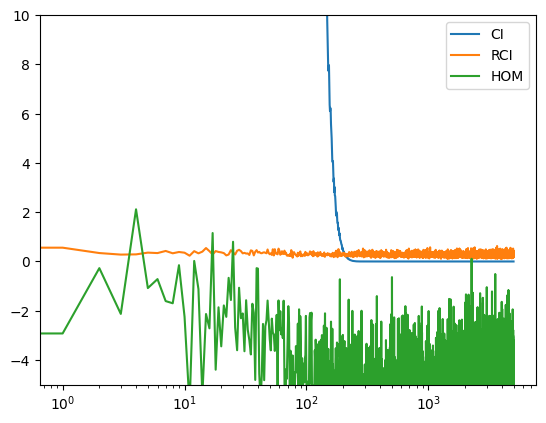

In [5]:
plt.plot(loss_history_CI)
plt.plot(loss_history_RCI)
plt.plot(loss_history_HOM)
plt.legend(['CI','RCI','HOM'])
plt.xscale('log')
#plt.xlim(100,2000)
plt.ylim(-5,10)

In [6]:
#evaluate metrics 
metrics = [model_CI.loss_fn, model_RCI.loss_fn, model_HOM.loss_fn]
models = [model_rand, model_CI, model_RCI, model_HOM]
model_types = [Similitude2(ncells=N_nrns), RobustSimilitude(ncells=N_nrns, p_magnitude=1e-1,r_magnitude=1e-1), Homology(ncells=N_nrns)]
n_perms = 100

model_hmap = np.zeros([len(models),len(metrics),n_perms])

for n in range(n_perms):
    rs = model_RCI.unit_cell.sample(nsamples_space)
    rs = torch.tensor(rs,dtype=torch.float32)
    for count1, mtric in enumerate(model_types):
        for count2, mod in enumerate(models):
            temp_model = model_types[count1]
            temp_model.set_phases(mod.phases)
            model_hmap[count2,count1,n] = temp_model.loss_fn(rs)

hmap_std = np.std(model_hmap,2)
model_hmap = np.mean(model_hmap,2)

([<matplotlib.axis.YTick at 0x7f985843fc70>,
 [Text(0, 0, 'random'),
  Text(0, 1, 'CI'),
  Text(0, 2, 'RCI'),
  Text(0, 3, 'HOM')])

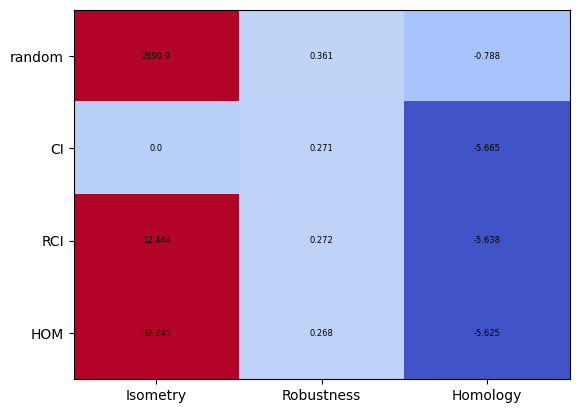

In [7]:
annotate_imshow(model_hmap,round_val=3,cmap='coolwarm',vmin=-6,vmax=10)
plt.xticks([0,1,2],['Isometry','Robustness','Homology'])
plt.yticks([0,1,2,3],['random','CI','RCI','HOM'])


Text(0.5, 1.0, 'Standard deviation')

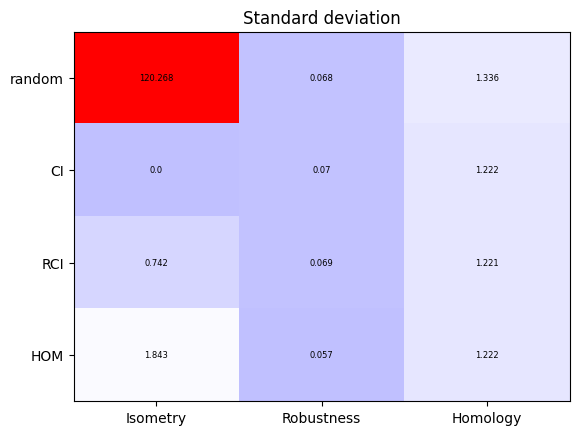

In [8]:
annotate_imshow(hmap_std,round_val=3,cmap='bwr',vmin=-6,vmax=10)
plt.xticks([0,1,2],['Isometry','Robustness','Homology'])
plt.yticks([0,1,2,3],['random','CI','RCI','HOM'])
plt.title('Standard deviation')